## Assignment:

Beat the performance of my Lasso regression by **using different feature engineering steps ONLY!!**.

The performance of my current model, as shown in this notebook is:

- test mse: 1063016789.3316755
- test rmse: 32603.938248801718
- test r2: 0.8453144708738004

To beat my model you will need a test r2 bigger than 0.85 and a rmse smaller than 32603.


=====================================================================================================


### Conditions:

- You MUST NOT change the hyperparameters of the Lasso.
- You MUST use the same seeds in Lasso and train_test_split as I show in this notebook (random_state)
- You MUST use all the features of the dataset (except Id) - you MUST NOT select features


=====================================================================================================


### If you beat my model:

Make a pull request with your notebook to this github repo:
https://github.com/solegalli/udemy-feml-challenge

And add your notebook to the folder:

-StudentsSolutions_v1.0.0

### How to make the PR

1) fork the repo:

Go to https://github.com/solegalli/udemy-feml-challenge, and click on the **fork** button at the top-right

2) clone your forked repo into your local computer:

- Go to www.github.com/yourusername/udemy-feml-challenge
- Click the green button that says clone or download
- copy the url that opens up
- power up a git console
- type: git clone (paste the url you copied from github)
- done

3) Make a copy of the jupyter notebook and add your name:

- Open up the Jupyter notebook called 13-Assignement.ipynb
- Click the "File" button at the top-right and then click "Make a copy"
- **Work your solution in the Copy** and not in the original assignment (otherwise there will be conflicts when making the PR)
- Change the name of the copy of the notebook to: 13-Assignement_yourname.ipynb
- Move the notebook to the folder **StudentsSolutions_v1.0.0**
- done

When you finish, just commit the new notebook to your fork and then make a PR to my repo.

- git add StudentsSolutions_v1.0.0/13-Assignement_yourname.ipynb
- git commit -m "your commit message"
- git push origin master or git push origin yourfeaturebranch
- go to your repo and make a pull request.


## But i have a notebook ready and I haven't cloned the repo yet, how can I make the PR?

If you worked in the copy you downloaded from Udemy before forking and cloning this repo, then follow this steps:

1) fork the repo:

Go to https://github.com/solegalli/udemy-feml-challenge, and click on the fork button at the top-right

2) clone your forked repo into your local computer:

Go to www.github.com/yourusername/udemy-feml-challenge

- Click the green button that says clone or download
- Copy the url that opens up
- Power up a git console
- Type: git clone (paste the url you copied from github)
- Done

3) Rename your solution as follows and copy it into your cloned repo:

- Rename your solution notebook to: 13-Assignement_yourname.ipynb
- Copy this file into the cloned repo, inside the folder **StudentsSolutions_v1.0.0**
- Done

When you finish, just commit the new notebook to your fork and then make a PR to my repo

- git add StudentsSolutions_v1.0.0/13-Assignement_yourname.ipynb
- git commit -m "your commit message"
- git push origin master or git push origin yourfeaturebranch
- go to your repo and make a pull request.

**Good luck!!**

## House Prices dataset

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

### Load Datasets

In [13]:
# load dataset

data = pd.read_csv('../houseprice.csv')

In [14]:
# make lists of variable types

categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('There are {} continuous variables'.format(len(numerical)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} temporal variables'.format(len(year_vars)))
print('There are {} categorical variables'.format(len(categorical)))

There are 18 continuous variables
There are 14 discrete variables
There are 4 temporal variables
There are 43 categorical variables


### Separate train and test set

In [15]:
# IMPORTANT: keep the random_state to zero for reproducibility
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

In [16]:
# calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [17]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [18]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

## Feature Engineering Pipeline

In [19]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [20]:
house_pipe = Pipeline([

    # missing data imputation - section 4
    ('missing_ind',
     mdi.AddMissingIndicator(
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),

    ('imputer_num',
     mdi.MeanMedianImputer(
         imputation_method='median',
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),

    ('imputer_cat', mdi.CategoricalImputer(variables=categorical)),


    # categorical encoding - section 6
    ('rare_label_enc',
     ce.RareLabelEncoder(tol=0.05, n_categories=1, variables=categorical + discrete)),

    # newly available categorical encoder, uses trees predictions
    ('categorical_enc',
     ce.DecisionTreeEncoder(random_state=2909, variables=categorical + discrete)),

    # discretisation - section 8
    ('discretisation',
     dsc.DecisionTreeDiscretiser(random_state=2909, variables=numerical)),

    # feature Scaling - section 10
    ('scaler', StandardScaler()),

    # regression
    ('lasso', Lasso(random_state=0))
])

## Set up the Grid ad the cross-validation strategy

In [21]:
# now we create the grid with all the parameters that we would like to test

param_grid = {
    # try different feature engineering parameters
    'rare_label_enc__tol': [0.01, 0.02, 0.03, 0.04, 0.05]
}


# now we set up the grid search with cross-validation
grid_search = GridSearchCV(house_pipe, param_grid,
                           cv=5, n_jobs=-1, scoring='r2')

# cv=5 is the cross-validation steps
# no_jobs =-1 indicates to use all available cpus
# scoring='r2' indicates to evaluate the model performance with the r2

# for more details in the grid parameters visit:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [22]:
# and now we train over all the possible combinations of the parameters above
grid_search.fit(X_train, y_train)


/Users/tajinder/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  category=UserWarning


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('missing_ind',
                                        AddMissingIndicator(variables=['LotFrontage',
                                                                       'MasVnrArea',
                                                                       'GarageYrBlt'])),
                                       ('imputer_num',
                                        MeanMedianImputer(variables=['LotFrontage',
                                                                     'MasVnrArea',
                                                                     'GarageYrBlt'])),
                                       ('imputer_cat',
                                        CategoricalImputer(variables=['MSZoning',
                                                                      'Street',
                                                                      'Alley',
                                                             

In [23]:
# and we print the best score over the train set
print(("best roc-auc from grid search: %3f"
       % grid_search.score(X_train, y_train)))

best roc-auc from grid search: 0.905531


In [24]:
# we can print the best estimator parameters like this
grid_search.best_estimator_

Pipeline(steps=[('missing_ind',
                 AddMissingIndicator(variables=['LotFrontage', 'MasVnrArea',
                                                'GarageYrBlt'])),
                ('imputer_num',
                 MeanMedianImputer(variables=['LotFrontage', 'MasVnrArea',
                                              'GarageYrBlt'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['MSZoning', 'Street', 'Alley',
                                               'LotShape', 'LandContour',
                                               'Utilities', 'LotConfig',
                                               'LandSlope', 'Neighborhood',
                                               'Condit...
                 DecisionTreeDiscretiser(param_grid={'max_depth': [1, 2, 3, 4]},
                                         random_state=2909,
                                         variables=['LotFrontage', 'LotArea',
                                            

In [25]:
grid_search.best_params_

{'rare_label_enc__tol': 0.01}

In [26]:
# let's get the predictions
X_train_preds = grid_search.predict(X_train)
X_test_preds = grid_search.predict(X_test)

In [27]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds, squared=True)))
print('train rmse: {}'.format(mean_squared_error(y_train, X_train_preds, squared=False)))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds,squared=True)))
print('test rmse: {}'.format(mean_squared_error(y_test, X_test_preds, squared=False)))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 589851625.6986735
train rmse: 24286.861174278438
train r2: 0.9055305079703659

test mse: 923125269.4375038
test rmse: 30382.97663885986
test r2: 0.8656708697494032


Text(0, 0.5, 'Predicted Price')

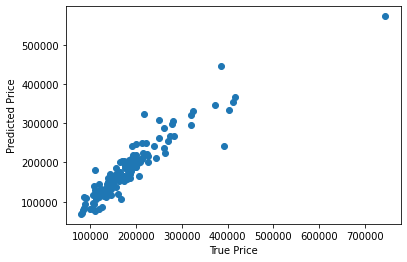

In [28]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

<AxesSubplot:>

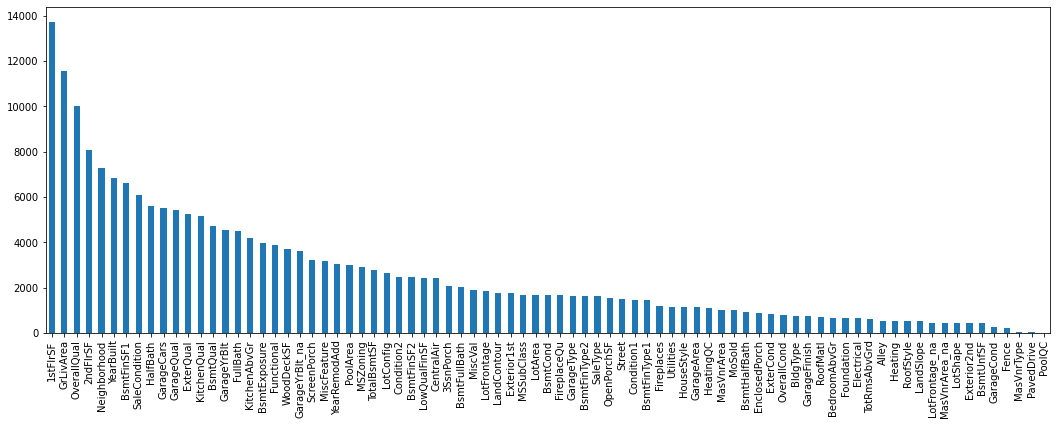

In [29]:
# let's explore the importance of the features
# the importance is given by the absolute value of the coefficient
# assigned by the Lasso

importance = pd.Series(np.abs(grid_search.best_estimator_['lasso'].coef_))
importance.index = list(final_columns)+['LotFrontage_na', 'MasVnrArea_na',  'GarageYrBlt_na']
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))